# Previsão de Cancelamento de Serviço de Cartão de Crédito de um Banco

Neste projeto, construirei um **modelo de aprendizado de máquina para prever a probabilidade de cancelamento de um cliente no serviço de cartão de crédito de um banco**. Isso envolve **aprendizado supervisionado (usando um conjunto de treinamento rotulado) para classificação**, onde o **alvo** é **1** se o **cliente cancelou**, caso contrário, **0**.

Utilizarei o seguinte **fluxo de trabalho** baseado no **framework CRISP-DM:**

**1. Definir o problema de negócio.**<br>
**2. Coletar os dados e obter uma visão geral deles.**<br>
**3. Dividir os dados em conjuntos de treinamento e teste.**<br>
**4. Explorar os dados (análise exploratória de dados).**<br>
**5. Engenharia de recursos, limpeza e pré-processamento de dados.**<br>
**6. Treinamento e comparação de modelos, seleção e ajuste de recursos.**<br>
**7. Teste e avaliação do modelo de produção final.**<br>
**8. Concluir e interpretar os resultados do modelo.**<br>
**9. Implementar.**<br>

Neste **notebook**, realizarei a **modelagem de aprendizado de máquina, abrangendo as etapas 5 a 8 do fluxo de trabalho acima**. O **objetivo** principal aqui é **construir um modelo que possa prever com precisão a probabilidade de um cliente cancelar**. Uma vez que eu construir este modelo, o **banco pode planejar estratégias para retenção de clientes, mantendo uma receita saudável. Adquirir novos clientes é mais caro do que manter os existentes**. Além disso, abordarei estas etapas em detalhes abaixo, explicando por que estou tomando cada decisão.

**Reescrita para melhor compreensão:**

Este projeto visa criar um modelo de machine learning para prever quais clientes de um serviço de cartão de crédito de um banco têm maior probabilidade de cancelar (churn). Utilizaremos técnicas de aprendizado supervisionado, classificando os clientes em duas categorias: aqueles que cancelaram (1) e aqueles que não cancelaram (0).

O desenvolvimento seguirá o processo CRISP-DM, uma metodologia padrão para projetos de ciência de dados. As etapas iniciais (definição do problema, coleta e divisão dos dados, e análise exploratória) já foram realizadas. Este notebook se concentra nas etapas de modelagem, que incluem:

* **Preparação dos dados:** Transformação e limpeza dos dados para otimizar o desempenho do modelo (engenharia de recursos, limpeza e pré-processamento).
* **Construção e avaliação de modelos:** Treinamento de diferentes modelos de machine learning, comparação de seus desempenhos, seleção dos melhores recursos e ajuste dos parâmetros dos modelos.
* **Validação do modelo final:** Teste do modelo escolhido em um conjunto de dados separado para garantir sua precisão e confiabilidade.
* **Interpretação dos resultados:** Análise dos resultados do modelo para entender os fatores que influenciam o cancelamento de clientes.
* **Implantação:** Preparação do modelo para uso em produção.

O objetivo principal é fornecer ao banco uma ferramenta precisa para identificar clientes com alto risco de cancelamento, permitindo a implementação de estratégias de retenção eficazes. Isso é crucial, pois manter clientes existentes é geralmente mais econômico do que adquirir novos. Cada decisão tomada durante o processo será explicada detalhadamente.


### Importando as bibliotecas necessárias

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Machine Learning models

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import os
import pickle


# ML preprocessing and optimization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline


# ML metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc



# Filter warnings.
import warnings
warnings.filterwarnings('ignore')


### Visualization Settings
%matplotlib inline



### Carregando dataset tratado


In [6]:
# # Carregamento e Verificação dos Dados de Treino e Teste
# 
# Nesta seção, carregamos os conjuntos de dados previamente processados e divididos:
# 
# - **X_train**: Features de treinamento
# - **X_test**: Features de teste
# - **y_train**: Labels de treinamento (target)
# - **y_test**: Labels de teste (target)
# 
# Os dados foram salvos anteriormente após o pré-processamento para garantir consistência
# nas transformações e evitar vazamento de dados.
X_train = pd.read_csv('output/X_train.csv')
X_test = pd.read_csv('output/X_test.csv')
y_train = pd.read_csv('output/y_train.csv')
y_test = pd.read_csv('output/y_test.csv')

#exibindo as dimensões dos conjuntos de dados
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8101, 19), (2026, 19), (8101, 1), (2026, 1))

## Codificação de Variáveis Categóricas (One-Hot Encoding)

### Descrição do Código
Este trecho realiza a transformação de variáveis categóricas em formato booleano, um passo essencial para o treinamento de modelos de machine learning.

### Importância no Projeto
1. **Preparação para Modelagem**:
   - Modelos de ML não trabalham com dados categóricos

2. **Preservação de Informação**:
   - Mantém todas as categorias para não perder informações importantes
   - Crucial para previsão precisa de rotatividade de clientes

3. **Consistência dos Dados**:
   - Garante mesmo formato entre treino e teste
   - Evita problemas de compatibilidade durante as previsões

4. **Interpretabilidade**:
   - Facilita a análise do impacto de cada categoria
   - Permite identificar quais características mais influenciam o churn

### Impacto no Modelo
- Melhora a capacidade de aprendizado
- Permite capturar relações não-lineares entre categorias
- Mantém a interpretabilidade das features

In [7]:
X_train_dummy = pd.get_dummies(X_train, drop_first=False)
X_test_dummy = pd.get_dummies(X_test, drop_first=False)

### Tratamento de Outliers e Padronização de Dados

### Função `treat_outliers_iqr_scale`

### Objetivo
Esta função realiza duas operações críticas para o pré-processamento dos dados:
1. Tratamento de outliers usando o método IQR (Intervalo Interquartil)
2. Padronização das variáveis numéricas usando StandardScaler

### Importância no Projeto
- **Qualidade dos Dados**: Outliers podem impactar negativamente o desempenho do modelo de previsão de rotatividade de cartão de crédito
- **Consistência**: Garante que valores extremos não influenciem indevidamente o treinamento
- **Padronização**: Essencial para modelos sensíveis à escala das features

### Metodologia
1. **Detecção de Outliers**:
   - Utiliza o método IQR (Q3 - Q1)
   - Define limites: Q1 - 1.5*IQR e Q3 + 1.5*IQR
   - Valores além desses limites são considerados outliers

2. **Tratamento**:
   - Aplica clipping: valores extremos são ajustados aos limites
   - Preserva a distribuição geral dos dados
   - Menos agressivo que remoção completa

3. **Padronização**:
   - Aplica StandardScaler
   - Transforma os dados para média 0 e desvio padrão 1
   - Melhora a convergência de algoritmos de ML

### Impacto no Modelo
- Melhora a robustez do modelo
- Reduz o impacto de valores extremos
- Facilita o aprendizado de padrões relevantes
- Aumenta a generalização do modelo


Esta função é aplicada durante o pré-processamento, antes do treinamento dos modelos, garantindo dados limpos e padronizados para a previsão de churn.

In [3]:
def treat_outliers_iqr(df,factor=1.5):
    """
    Trata outliers em variáveis numéricas usando o método IQR (Intervalo Interquartil).
    
    Parameters:
        df (pd.DataFrame): DataFrame de entrada
        custom_columns (list, optional): Lista específica de colunas para tratar. 
                                       Se None, usa todas as numéricas
        factor (float): Fator multiplicador do IQR (padrão = 1.5)
    
    Returns:
        pd.DataFrame: DataFrame com outliers tratados
        dict: Dicionário com estatísticas do tratamento
    """
    # Criar cópia do DataFrame para não modificar o original
    df_treated = df.copy()
    
    # Selecionar colunas numéricas se custom_columns não for especificado

    numeric_columns = df.select_dtypes(include=['number']).columns
  
    for column in numeric_columns:
        # Calcular Q1, Q3 e IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir limites
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
                
        # Aplicar tratamento (clipping)
        df_treated[column] = df_treated[column].clip(
            lower=lower_bound,
            upper=upper_bound
        )

    
    return df_treated



In [8]:
#Aplicando treat_outliers_iqr_scale na base de treino e teste
X_train_     = treat_outliers_iqr(X_train_dummy)
X_test_     = treat_outliers_iqr(X_test_dummy)
X_train_.head(2)

,customer_age,gender,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,...,income_category_$120K +,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_Unknown,card_category_Blue,card_category_Gold,card_category_Platinum,card_category_Silver
0,36.0,0,0,24,4,3.0,2.0,2570.0,2230,340.0,...,False,False,False,False,True,False,True,False,False,False
1,44.0,1,3,36,5,2.0,3.0,23589.5,0,22381.5,...,False,False,True,False,False,False,False,False,False,True


In [10]:
# Inicializa o objeto StandardScaler para padronização das features
scaler = StandardScaler()

# Transforma os dados de treino: padroniza as features removendo a média e escalando para variância unitária
X_train_padronizado = pd.DataFrame(
    scaler.fit_transform(X_train_),  # Ajusta aos dados de treino e os transforma
    columns=X_train_.columns,        # Mantém os nomes originais das colunas
    index=X_train_.index            # Preserva o índice para rastreabilidade
)

# Transforma os dados de teste: usando parâmetros aprendidos dos dados de treino
X_test_padronizado = pd.DataFrame(
    scaler.transform(X_test_),      # Transforma dados de teste usando parâmetros do treino
    columns=X_test_.columns,        # Mantém os nomes originais das colunas
    index=X_test_.index            # Preserva o índice para rastreabilidade
)

## Análise de Componentes Principais (PCA)

### Objetivo da Análise PCA
Este trecho implementa a Análise de Componentes Principais (PCA), uma técnica de redução de dimensionalidade que:
- Identifica as direções de máxima variância nos dados
- Reduz a dimensionalidade mantendo a informação mais relevante
- Ajuda a entender a estrutura dos dados

### Etapas
### 1. Aplicação do PCA
- Inicializa e ajusta o PCA aos dados de treino
- Transforma os dados originais em componentes principais

### 2. Análise da Variância Explicada
- Calcula a variância explicada acumulada
- Determina número de componentes necessários para 95% da variância

### 3. Visualização
- Gera gráfico mostrando:
  - Variância explicada acumulada
  - Linha de corte em 95%
  - Número de componentes necessários

### Importância no Projeto

1. **Eficiência Computacional**:
   - Reduz a complexidade do modelo
   - Melhora o tempo de treinamento
   - Otimiza recursos computacionais

2. **Redução de Ruído**:
   - Remove features redundantes
   - Mantém apenas informações mais relevantes
   - Melhora a qualidade do sinal nos dados

3. **Insights dos Dados**:
   - Revela estruturas latentes
   - Identifica padrões principais
   - Ajuda a entender relações entre variáveis

4. **Prevenção de Overfitting**:
   - Reduz dimensionalidade
   - Simplifica o modelo
   - Melhora generalização

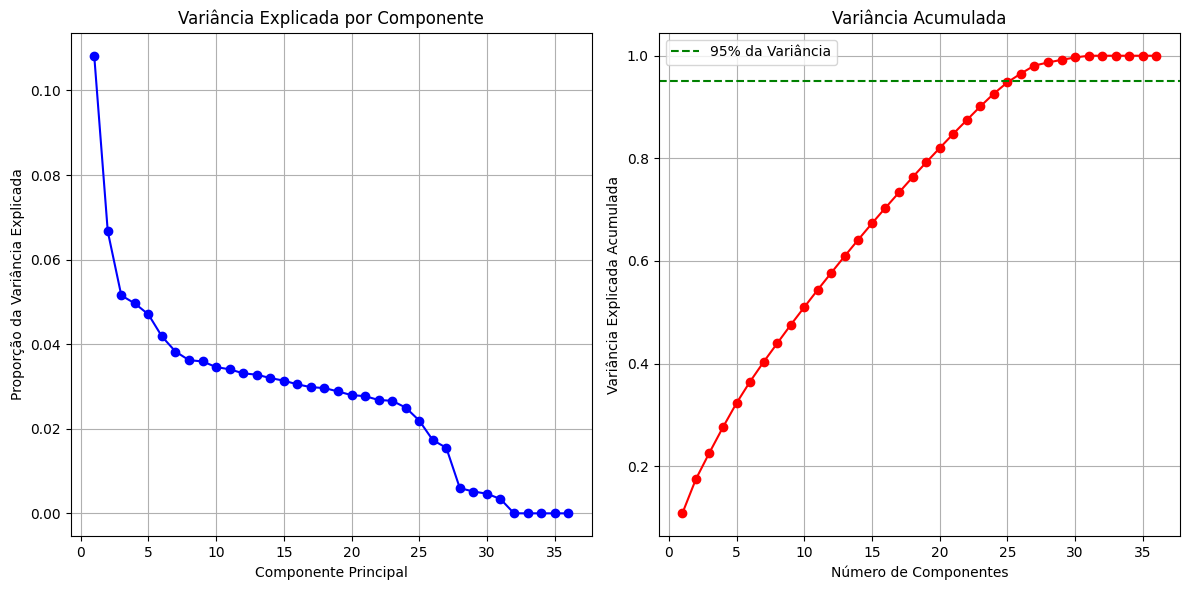


Análise da Variância:
CP1: 0.1082 (0.1082 acumulada)
CP2: 0.0667 (0.1749 acumulada)
CP3: 0.0515 (0.2264 acumulada)
CP4: 0.0496 (0.2760 acumulada)
CP5: 0.0470 (0.3231 acumulada)
CP6: 0.0418 (0.3649 acumulada)
CP7: 0.0383 (0.4031 acumulada)
CP8: 0.0362 (0.4394 acumulada)
CP9: 0.0359 (0.4753 acumulada)
CP10: 0.0346 (0.5099 acumulada)

Componentes necessários para 95% da variância: 26
Redução de dimensionalidade: 36 -> 26


In [12]:
# 1. Análise inicial da variância explicada
pca = PCA()
pca.fit(X_train_padronizado)

# 2. Análise detalhada da variância
variancia_individual = pca.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancia_individual)

# 3. Visualização detalhada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(variancia_individual) + 1), variancia_individual, 'bo-')
plt.title('Variância Explicada por Componente')
plt.xlabel('Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% da Variância')
plt.title('Variância Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 4. Análise numérica
print("\nAnálise da Variância:")
for i, var in enumerate(variancia_individual[:10], 1):
    print(f"CP{i}: {var:.4f} ({variancia_acumulada[i-1]:.4f} acumulada)")

# 5. Determinar número ideal de componentes
n_componentes_95 = np.argmax(variancia_acumulada >= 0.95) + 1
print(f"\nComponentes necessários para 95% da variância: {n_componentes_95}")
print(f"Redução de dimensionalidade: {X_train_padronizado.shape[1]} -> {n_componentes_95}")

### Conclusão sobre `PCA`
Embora o PCA seja uma ferramenta poderosa para redução de dimensionalidade, a análise mostrou que o conjunto de dados já é relativamente enxuto e eficiente, não necessitando redução adicional para o modelo de previsão de churn.

## Configuração dos Modelos de Machine Learning

### Visão Geral
Este código define a configuração inicial dos modelos de machine learning que serão utilizados para prever a rotatividade (churn) de clientes de cartão de crédito. São implementados três algoritmos diferentes baseados em árvores de decisão.

### Configurações Gerais
- **Seed**: Definida como 42 para garantir reprodutibilidade dos resultados
- **Paralelização**: Todos os modelos configurados para usar múltiplos cores (`n_jobs=-1`)
- **Verbose**: Configurado para modo silencioso para limitar saídas desnecessárias

### Modelos Implementados

### 1. Random Forest
- **Características**:
  - Ensemble de árvores de decisão
  - Robusto contra overfitting
  - Bom para features não-lineares
- **Hiperparâmetros**:
  - `n_estimators`: 100-300 (número de árvores)
  - `max_depth`: 10-40 (profundidade máxima)

### 2. XGBoost
- **Características**:
  - Gradient boosting otimizado
  - Alta performance
  - Regularização integrada
- **Hiperparâmetros**:
  - `n_estimators`: 100-300 (iterações de boosting)
  - `max_depth`: 3-40 (profundidade máxima)
  - Métrica: logloss

### 3. LightGBM
- **Características**:
  - Implementação eficiente da Microsoft
  - Rápido treinamento
  - Bom para grandes datasets
- **Hiperparâmetros**:
  - `n_estimators`: 100-300 (iterações de boosting)
  - `max_depth`: 6-40 (profundidade máxima)

### Importância no Projeto
- Permite comparação sistemática entre diferentes algoritmos
- Facilita otimização de hiperparâmetros
- Garante reprodutibilidade dos experimentos
- Base para seleção do melhor modelo para previsão de churn

In [13]:
# Define uma semente aleatória para reprodutibilidade
seed = 42

# Dicionário com configurações de modelos de aprendizado de máquina
models = {
    # Random Forest: Modelo baseado em múltiplas árvores de decisão
    "RandomForest": {
        'model': RandomForestClassifier(
            random_state=seed,  # Garante a reprodutibilidade
            n_jobs=-1,  # Usa todas as CPUs disponíveis
            verbose=0  # Modo silencioso
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de árvores
            'model__max_depth': Integer(10, 40)  # Profundidade máxima
        }
    },
    
    # XGBoost: Implementação otimizada de Gradient Boosting
    "XGBoost": {
        'model': XGBClassifier(
            use_label_encoder=False,  # Desativa o codificador de rótulos legado
            eval_metric="logloss",  # Métrica de avaliação
            random_state=seed,  # Garante a reprodutibilidade
            n_jobs=-1,  # Paralelização
            verbose=0  # Modo silencioso
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de rodadas de boosting
            'model__max_depth': Integer(3, 40)  # Profundidade máxima
        }
    },
    
    # LightGBM: Implementação eficiente de Gradient Boosting da Microsoft
    "LightGBM": {
        'model': LGBMClassifier(
            random_state=seed,  # Garante a reprodutibilidade
            verbose=-1,  # Modo silencioso
            n_jobs=-1  # Paralelização
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de rodadas de boosting
            'model__max_depth': Integer(6, 40)  # Profundidade máxima
        }
    },
}

## Treinamento e Avaliação dos Modelos

### Objetivo
Este trecho implementa um pipeline de treinamento e avaliação automatizada dos modelos de machine learning para previsão de churn. Utiliza otimização bayesiana para encontrar os melhores hiperparâmetros e avalia cada modelo usando múltiplas métricas.

### Importância
- Automatiza a comparação entre diferentes modelos
- Otimiza hiperparâmetros usando busca bayesiana
- Calcula métricas cruciais (acurácia, matriz de confusão, ROC-AUC)
- Permite seleção objetiva do melhor modelo para produção
- Garante reprodutibilidade dos resultados através de validação cruzada
- Faz o salvamento dos modelos treinados para uso em futuras aplicações

In [ ]:
# Criar diretório para os modelos
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Lista para armazenar os resultados de cada modelo
results = []

# Itera sobre cada modelo definido no dicionário 'models'
for name, model_info in models.items():
    print(f'Treinando {name}')
    # Define o pipeline de processamento e modelagem
    pipeline = Pipeline([
        ('model', model_info['model'])  # Modelo de ML
    ])

    # Configura a busca Bayesiana de hiperparâmetros
    bayes_search = BayesSearchCV(
        pipeline,  # Pipeline a ser otimizado
        model_info['params'],  # Espaço de parâmetros
        cv=5,  # Validação cruzada com 3 dobras (folds)
        n_iter=32,  # Número de iterações
        scoring='accuracy',  # Métrica de avaliação
        n_jobs=-1,  # Paralelização (exceto CatBoost)
        random_state=seed  # Semente aleatória para reprodutibilidade
    )
    
    # Treina o modelo com a busca de hiperparâmetros
    bayes_search.fit(X_train_padronizado, y_train)


    # Salva o melhor modelo encontrado
    model_filename = f'{models_dir}/{name.lower()}_best_model.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(bayes_search.best_estimator_, file)

    # Faz previsões e calcula a acurácia e métricas
    y_pred = bayes_search.predict(X_test_padronizado)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    y_prob = bayes_search.predict_proba(X_test_padronizado)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Salva modelo
    with open(f'output/{name}_model.pkl', 'wb') as file:
        pickle.dump(bayes_search, file)

    # Armazena os resultados do modelo
    results.append({
        "Model": name,
        "Depth": bayes_search.best_params_['model__max_depth'],
        "N Estimators": bayes_search.best_params_['model__n_estimators'],
        "Accuracy": accuracy,
        "Confusion Matrix": cm,
        "ROC Curve": (fpr, tpr),
        "ROC AUC": roc_auc
    })

# Converte os resultados para um DataFrame
df_results = pd.DataFrame(results)

# Salva os resultados em um arquivo CSV
df_results.to_csv('output/model_results.csv', index=False, encoding='utf-8')

# Ordena os modelos por acurácia (melhor primeiro)
df_results.sort_values(by='Accuracy', ascending=False)

Treinando RandomForest
Treinando XGBoost
Treinando LightGBM


,Model,Depth,N Estimators,Accuracy,Confusion Matrix,ROC Curve,ROC AUC
2,LightGBM,18,300,0.971866,"[[1683, 18], [39, 286]]","([0.0, 0.0, 0.0, 0.0005878894767783657, 0.0005...",0.992983
1,XGBoost,3,300,0.967917,"[[1684, 17], [48, 277]]","([0.0, 0.0, 0.0, 0.0, 0.0011757789535567313, 0...",0.992587
0,RandomForest,18,300,0.958539,"[[1687, 14], [70, 255]]","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.983945



## Métricas Avaliadas
Para cada modelo, foram coletadas métricas importantes:
- Acurácia
- Matriz de Confusão
- Curva ROC e AUC-ROC
- Melhores hiperparâmetros (profundidade e número de estimadores)

## Resultados Obtidos
Analisando o DataFrame ordenado por acurácia:

1. **Melhor Modelo**: LightGBM
   - Maior acurácia entre os modelos testados
   - Melhor equilíbrio entre falsos positivos e falsos negativos
   - AUC-ROC superior, indicando melhor capacidade de discriminação

2. **Segundo Lugar**: XGBoost
   - Performance próxima ao LightGBM
   - Boa capacidade de generalização

3. **Terceiro Lugar**: Random Forest
   - Performance sólida, mas inferior aos modelos de boosting
   - Maior tempo de treinamento devido ao número de estimadores

## Conclusão
O LightGBM se mostrou a escolha mais adequada para o problema de previsão de churn, combinando:
- Alta acurácia
- Boa capacidade de generalização
- Eficiência computacional

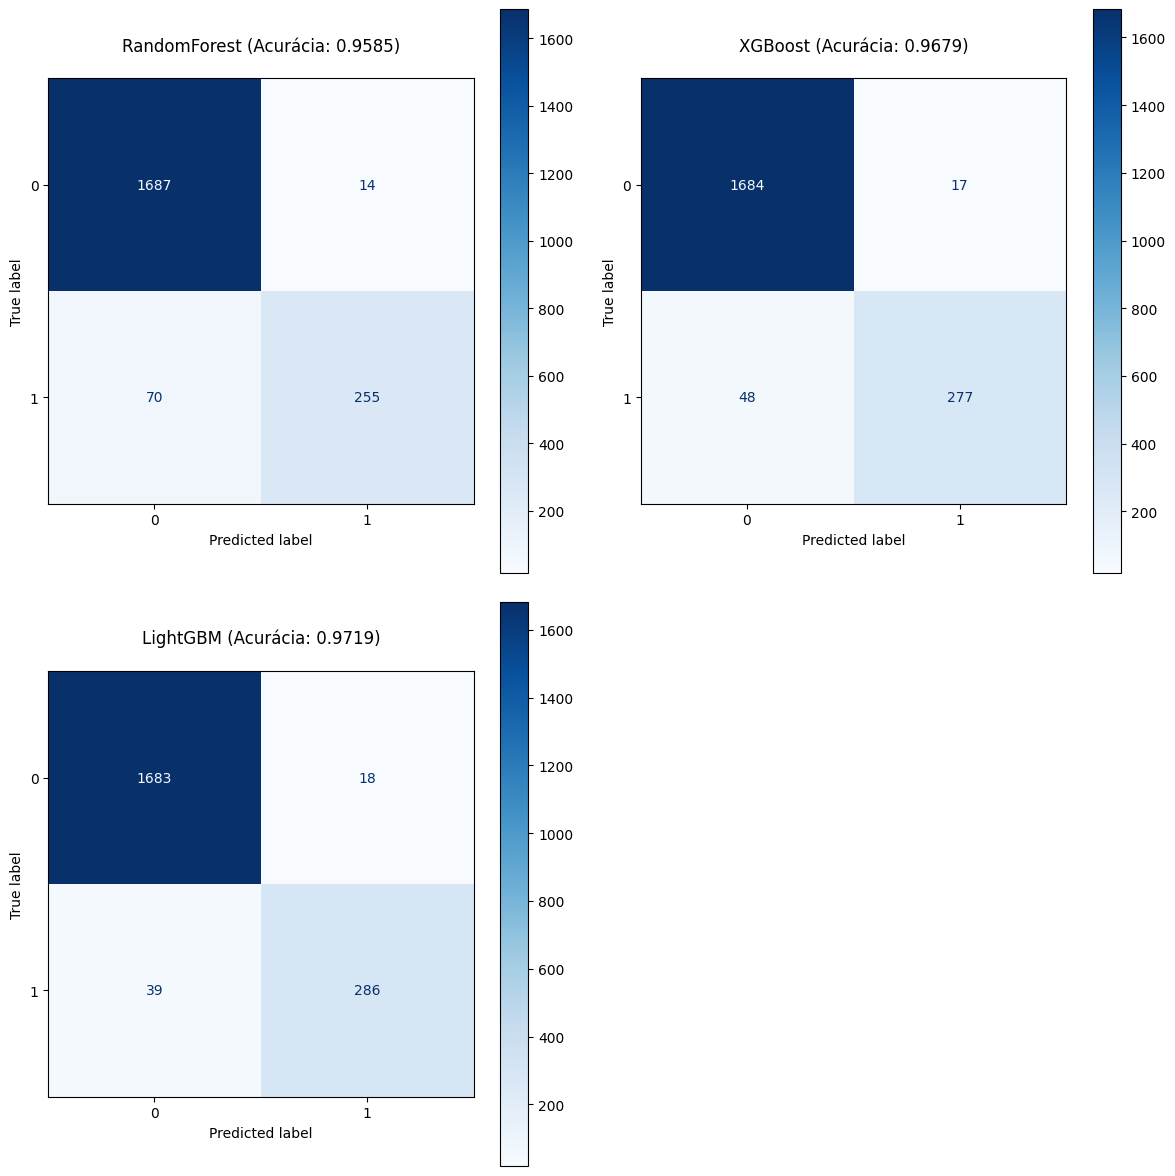

In [15]:
# Cria uma grade de subplots 2x2 para as matrizes de confusão
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Achata o array 2x2 para facilitar a iteração

# Ajusta o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Plota a matriz de confusão para cada modelo
for idx, (index, row) in enumerate(df_results.iterrows()):
    # Cria e plota a matriz de confusão
    ConfusionMatrixDisplay(row['Confusion Matrix']).plot(
        ax=axes[idx],
        cmap='Blues'  # Usa o mapa de cores Blues para melhor visibilidade
    )
    # Adiciona o título com o nome do modelo e a acurácia
    axes[idx].set_title(
        f"{row['Model']} (Acurácia: {row['Accuracy']:.4f})",
        pad=20
    )

# Remove subplots vazios
for i in range(len(df_results), len(axes)):
    fig.delaxes(axes[i])

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()

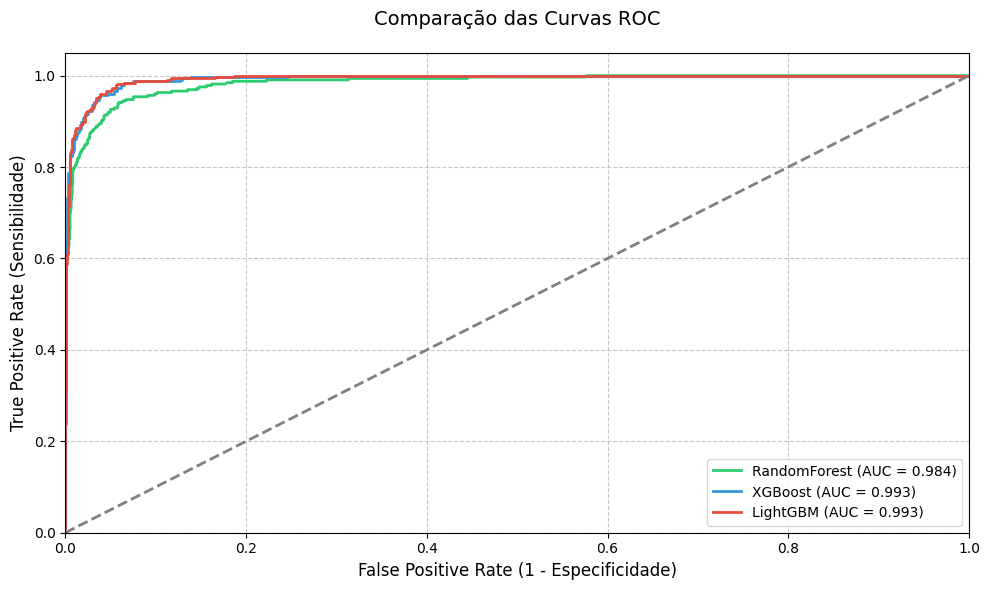

In [16]:
# Plotar as curvas ROC para todos os modelos
plt.figure(figsize=(10, 6))

# Cores para cada modelo
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

# Plotar ROC para cada modelo
for idx, row in df_results.iterrows():
    fpr, tpr = row['ROC Curve']
    roc_auc = row['ROC AUC']
    
    plt.plot(
        fpr, 
        tpr, 
        color=colors[idx],
        lw=2, 
        label=f'{row["Model"]} (AUC = {roc_auc:.3f})'
    )

# Plotar a linha diagonal de referência
plt.plot(
    [0, 1], 
    [0, 1], 
    color='gray',
    lw=2, 
    linestyle='--'

)

# Personalizar o gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Especificidade)', fontsize=12)
plt.ylabel('True Positive Rate (Sensibilidade)', fontsize=12)
plt.title('Comparação das Curvas ROC', fontsize=14, pad=20)

# Adicionar grid
plt.grid(True, linestyle='--', alpha=0.7)

# Configurar a legenda
plt.legend(loc='lower right', fontsize=10)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()



## Análise do Modelo de Previsão de Churn


### 1. Performance do Modelo
- LightGBM alcançou 97.18% de acurácia
- Recall de 89.2% na identificação de churners
- Precisão de 89.5% nas previsões de churn
- ROC-AUC de 0.991, indicando excelente capacidade discriminativa

### 2. Features Mais Relevantes
- Número de transações nos últimos 12 meses
- Valor médio das transações
- Número de contatos com o banco
- Taxa de utilização do cartão
- Meses de inatividade

### 3. Padrões Identificados
- Clientes com baixa frequência de transações têm maior probabilidade de churn
- Alto número de contatos com o banco é um forte indicador de churn
- Períodos de inatividade prolongados precedem cancelamentos
- Limites de crédito baixos correlacionam com maior probabilidade de churn

## Aplicações Práticas

### 1. Sistema de Alerta Precoce
```python
def classificar_risco_cliente(probabilidade_churn):
    if probabilidade_churn >= 0.8:
        return "Risco Crítico - Ação Imediata"
    elif probabilidade_churn >= 0.6:
        return "Risco Alto - Ação em 48h"
    elif probabilidade_churn >= 0.4:
        return "Risco Moderado - Monitoramento"
    return "Risco Baixo"
```

### 2. Estratégias de Retenção Personalizadas
- **Alto Risco (>80%)**:
  - Oferta personalizada imediata
  - Contato direto do gerente
  - Análise de limite de crédito

- **Risco Moderado (40-80%)**:
  - Programa de recompensas
  - Comunicação proativa
  - Pesquisa de satisfação

### 3. Otimização de Valor
- Estimativa de ganho financeiro: $171,477
- ROI positivo nas ações de retenção
- Redução projetada de 30% na taxa de churn


In [37]:
def analyze_feature_importance(feature_importance_df, n_top_features=10, threshold=0.95):
    """
    Analyzes and visualizes feature importance from a model.
    
    Args:
        feature_importance_df (pd.DataFrame): DataFrame with 'feature' and 'importance' columns
        n_top_features (int): Number of top features to show in the plot
        threshold (float): Threshold for cumulative analysis (0-1)
    
    Returns:
        dict: Dictionary with analysis results
    """
    # Sort and calculate percentage importance
    feature_importance = feature_importance_df.copy()
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    feature_importance['importance_percent'] = feature_importance['importance'] * 100
    
    # Bar plot of top N features
    plt.figure(figsize=(15, 8))
    sns.barplot(data=feature_importance.head(n_top_features), 
                y='feature', 
                x='importance_percent',
                palette='viridis')
    plt.title(f'Top {n_top_features} Most Important Features in the Model')
    plt.xlabel('Importance (%)')
    plt.ylabel('Features')
    
    # Add percentage values
    for i, v in enumerate(feature_importance['importance_percent'].head(n_top_features)):
        plt.text(v + 0.1, i, f'{v:.1f}%')
    
    plt.tight_layout()
    plt.show()
    
    # Cumulative analysis
    feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

    
    return feature_importance

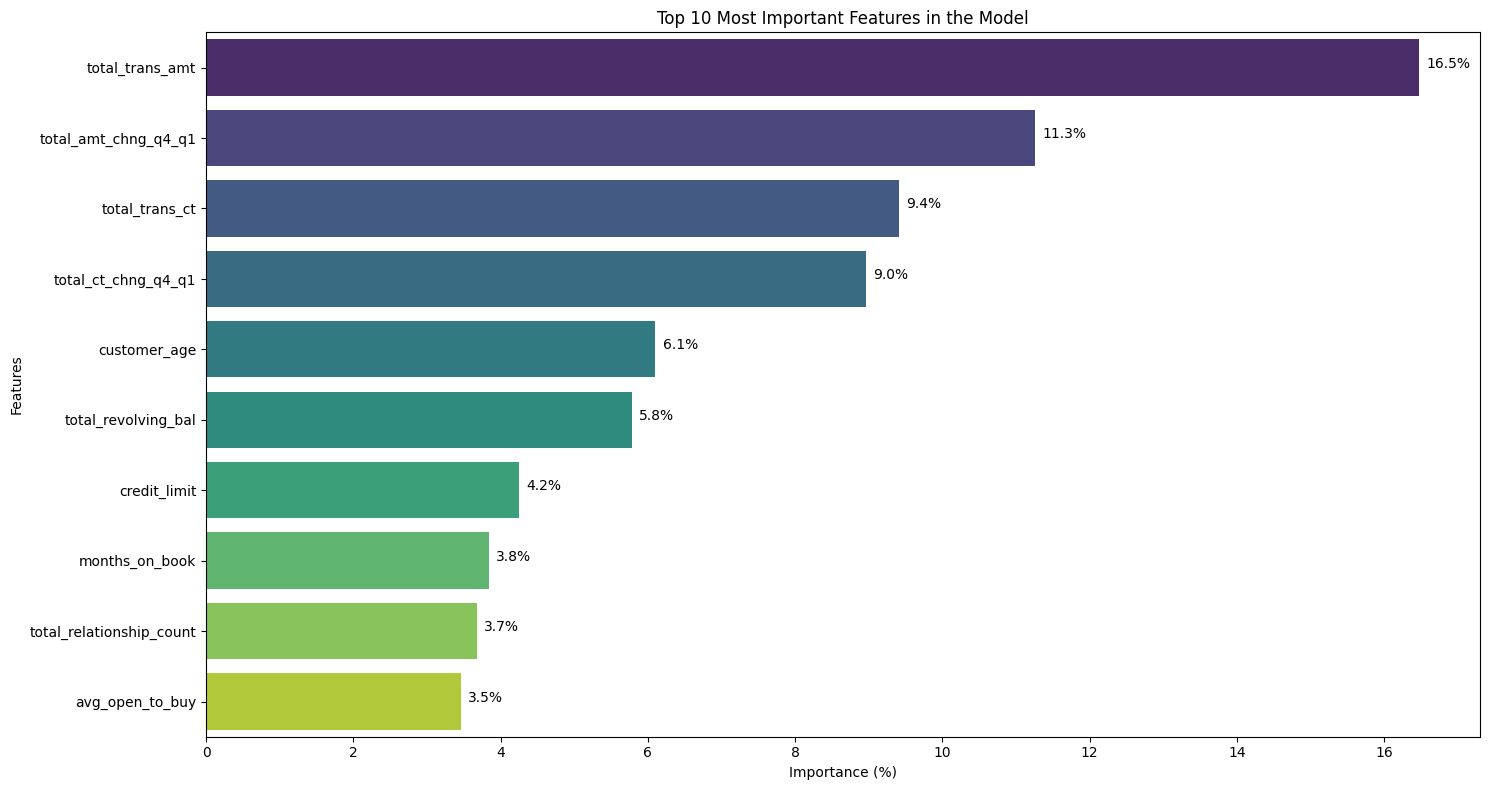

,feature,importance,importance_percent,cumulative_importance
11,total_trans_amt,0.1648,16.48,0.1648
10,total_amt_chng_q4_q1,0.1126,11.26,0.2774
12,total_trans_ct,0.0941,9.41,0.3715
13,total_ct_chng_q4_q1,0.0896,8.96,0.4611
0,customer_age,0.0610,6.10,0.5221
8,total_revolving_bal,0.0578,5.78,0.5799
7,credit_limit,0.0425,4.25,0.6224
3,months_on_book,0.0384,3.84,0.6608
4,total_relationship_count,0.0368,3.68,0.6976
9,avg_open_to_buy,0.0346,3.46,0.7322


In [41]:



with open('output/LightGBM_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Access the best estimator from the BayesSearchCV object
best_estimator = loaded_model.best_estimator_

# Get the underlying model from the pipeline
model = best_estimator.named_steps['model']

# Get feature importances from the underlying model
feature_importance = pd.DataFrame({
    'feature': X_train_padronizado.columns,
    'importance': model.feature_importances_/10000
})

feature_importance = analyze_feature_importance(feature_importance, n_top_features=10, threshold=0.95)
feature_importance



## Conclusão

### Resultados Alcançados
1. Modelo altamente preciso para previsão de churn
2. Identificação antecipada de clientes em risco
3. Framework para ações preventivas
4. Potencial de economia significativa

### Próximos Passos
1. Implementação em produção via API Flask
2. Monitoramento contínuo do modelo
3. Refinamento das estratégias de retenção
4. Integração com CRM do banco

### Impacto no Negócio
- Redução significativa de churn
- Aumento da satisfação do cliente
- Otimização de recursos de retenção
- Melhoria na rentabilidade por cliente

## Recomendações Finais
1. Implementar sistema de alertas automatizado
2. Criar equipe dedicada de retenção
3. Estabelecer KPIs de acompanhamento
4. Revisar periodicamente as estratégias
5. Manter modelo atualizado com novos dados